## Simulazione della fase  solida $\rho = 1.1 \,, T = 0.8$

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit

def myexp(x, a):
    return np.exp(-x/a) 

Come anticipato nell'Introductory notebook, in questo jupyter diamo alcune spiegazioni aggiuntive su come si è proceduto in generale durante l'esercizio, mentre negli altri ci limteremo a commentare i risultati quando necessario. 

Iniziamo dal calcolo delle incertezze statistiche.

### Valori medi e incertezze statistiche

Per poter calcolare medie e incertezze statistiche sul set di dati raccolti durante la simulazione e riguardanti le grandezze istantanee, dovremmo conoscere il tempo tipico di correlazione di queste grandezze. Per ottenere questa informazione si può procedere in due modi:
1. calcolare le funzioni di autocorrelazione delle varie grandezze, a partire dalle serie temporali raccolte, e trovare tramite un fit una stima del tempo di correlazione;
2. calcolare le deviazioni standard dalla media con il metodo del blocking e osservare come queste variano al variare del numero di step contenuti nel blocco.

### (1) Funzioni di autocorrelazione $\chi(t)$

In questa fase bisogna fare attenzione al range in cui si considera la funzione di autocorrelazione $\chi(t)$. Da un lato infatti $t$ deve essere abbastanza lungo da permettere di vedere il decadimento, ma dall'altro considerare tempi troppo lunghi porta a delle stime errate del tempo di decadimento, poichè nella zona $t \rightarrow t_{max}$ le fluttuazioni delle grandezze che stiamo misurando tendono a far "esplodere" la funzione $\chi(t)$. 

Il nostro sample è costituito da $t_{max} = 10^5$ step MC, ma in accordo con quanto appena detto, studieremo le funzioni di correlazione solo nel range $t \in [0, 200]$: come si vede dai grafici, questo è sufficiente per apprezzarne il decadimento.

In [5]:
obs = [np.loadtxt("Istantaneous/epot_solid.dat"),
       np.loadtxt("Istantaneous/pres_solid.dat")]

N = len(obs[0])
n = N//500

afs = [np.zeros(n), np.zeros(n)]

d = np.zeros(4)
for i in range(N):
    d[0] += obs[0][i]**2/N 
    d[1] += obs[0][i]/N
    d[2] += obs[1][i]**2/N 
    d[3] += obs[1][i]/N

D = [d[0] - d[1]**2, d[2] - d[3]**2] 

for i in range(n):
    x = [0,0]
    y = [0,0]
    z = [0,0]
    for j in range(N-i):
        for k in range(2):
            x[k] += obs[k][j]*obs[k][j+i]/(N-i)
            y[k] += obs[k][j]/(N-i)
            z[k] += obs[k][j+i]/(N-i)
    afs[0][i] = (x[0] - y[0] * z[0])/D[0]    
    afs[1][i] = (x[1] - y[1] * z[1])/D[1]


/home/alessandro/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


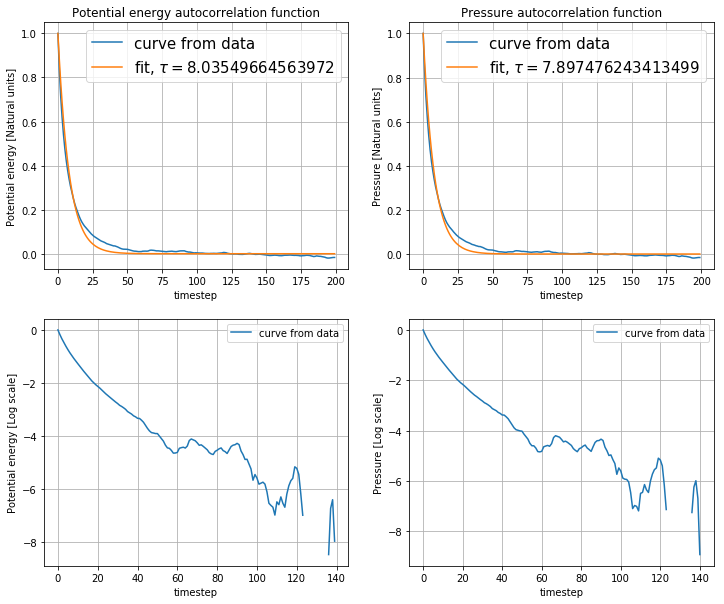

In [7]:
t = np.arange(n)
f = plt.figure(figsize = (12, 10))
text = ['Potential energy', 'Pressure']

for i in range(2):
    graph = f.add_subplot(2, 2, 1+i)
    graph.plot(t, afs[i], label = 'curve from data')
    p_opt, p_cov = curve_fit(myexp, t, afs[i]) 
    y_fit = myexp(t,p_opt[0])
    tau = str(p_opt[0])
    graph.plot(t, y_fit, label = 'fit, $ \u03C4 = $' + tau)
    plt.xlabel('timestep')
    plt.ylabel(text[i]+' [Natural units]')
    plt.title(text[i]+' autocorrelation function')
    plt.legend(prop={'size': 15})
    plt.grid()
    
for i in range(2):
    f.add_subplot(2, 2, 3+i)
    plt.plot(t, np.log(afs[i]), label = 'curve from data')
    plt.xlabel('timestep')
    plt.ylabel(text[i]+' [Log scale]')
    plt.legend()
    plt.grid()


Il fit con una curva esponenziale ci da il parametro $\tau$, ovvero il tempo impiegato dalle correlazioni per ridursi di un fattore $1/e$. Per studiare meglio il punto in cui le correlazioni toccano lo zero abbiamo plottato la stessa funzione di autocorrelazione in scala logaritmica: si vede così che le fluttuazioni diventano compatibili con lo zero in un tempo di circa 120 step MC.

### (2) Data blocking e dimensione dei blocchi

Anche in questo procedimento ci sono degli aspetti da controllare. In analogia con quanto detto per le funzioni di correlazione infatti, anche lo studio dei blocchi deve essere limitato all'interno di un certo range. Introduciamo ora della notazione per chiarire meglio questo concetto.

Chiamiamo $\alpha$ la dimensione di un blocco e $\beta$ il numero di blocchi corrispondenti, calcolato come $\beta = t_{max}/\alpha $: $\alpha$ e $\beta$ sono quindi due grandezze duali. Siamo interessati alla famiglia di quantità

$$
\sigma_{\alpha;\beta}^2 = \Big(\frac{1}{\beta}\sum_{k=0}^{\beta-1}{\mu_k^{(\alpha)}} ^2 -\big(\frac{1}{\beta}\sum_{k=0}^{\beta-1}\mu_k^{(\alpha)}\big)^2\Big)/\beta
$$
con
$$
\mu_k^{(\alpha)} = \frac{1}{\alpha}\sum_{i \in {[k\alpha, (k+1)\alpha)}} o(i) \; ,
$$

dove $o(i)$ è il valore allo step i-esimo dell'osservabile $o$ (nel nostro caso $o$ = energia potenziale, pressione).

Se vogliamo studiare l'andamento di $\sigma_{\alpha;\beta}^2 $ in funzione di $\alpha$, allora ci accorgiamo che per $\alpha = t_{max}$ si ha $\beta = 1$ e quindi

$$
\sigma_{t_{max};1}^2 = \Big({\mu_0^{(t_{max})}} ^2 -\big(\mu_0^{(t_{max})}\big)^2\Big)/\beta = 0
$$

Dunque lo studio dei blocchi ha senso innanzitutto solo per $\alpha < t_{max}$, ed essendo $\alpha$ una variabile necessariamente intera che divide $t_{max}$, questo limite diventa $\alpha \leq t_{max}/2\,$. Alla luce di questo fatto ci aspettiamo quindi che per $\alpha$ troppo prossimi alla dimensione della simulazione il valore dello scarto quadratico medio $\sigma_{\alpha;\beta}^2$ non fornisca più una stima fedele dell'errore sul valor medio della nostra osservabile, ed escluderemo quindi questa zona nello studio del blocking. 

Nel nostro caso, avendo $t_{max} = 10^5\,$, abbiamo limitato lo studio dei blocchi a una dimensione $\alpha \leq t_{max}/20 = 5000$. Il numero totale di divisori di $10^5$ in questo range è $29$ (abbiamo compreso il valore $\alpha = 1$), dunque abbiamo un totale di $29$ possibili valori per la dimensione di un blocco $\alpha$. Nei grafici sottostanti è riportato l'andamento di $\sigma_{\alpha;\beta}$ in funzione di questi.

In [19]:
dim = 29

dim_blk = np.zeros(dim)
num_blk = np.zeros(dim)

dix = np.zeros(36)

for i in range(6):
    for j in range(6):
        dix[6*i + j] = (2**j)*(5**i)

dix.sort()
for i in range(dim):
        dim_blk[i] = dix[i]
        num_blk[i] = N/dim_blk[i]

err = [np.zeros(dim), np.zeros(dim)]

for i in range(dim):
    ave_obs = [np.zeros(int(num_blk[i])), np.zeros(int(num_blk[i]))] #aggiorno a 0 le medie
    ave2 = [0,0]                                                     # nei blocchi
    ave = [0,0]
    for j in range(int(num_blk[i])):
        for k in range(int(j*dim_blk[i]), int((j+1)*dim_blk[i])):    
            ave_obs[0][j] += obs[0][k]/dim_blk[i]           #calcolo il valor medio     
            ave_obs[1][j] += obs[1][k]/dim_blk[i]           # all'interno di un blocco
    for j in range(int(num_blk[i])):
        ave2[0] += (ave_obs[0][j]**2)/num_blk[i]          # calcolo media e varianza 
        ave[0] += ave_obs[0][j]/num_blk[i]                # dei blocchi
        ave2[1] += (ave_obs[1][j]**2)/num_blk[i]
        ave[1] += ave_obs[1][j]/num_blk[i]
    err[1][i] = np.sqrt((ave2[1] - ave[1]**2)/num_blk[i])  #aggiorno il valore 
    err[0][i] = np.sqrt((ave2[0] - ave[0]**2)/num_blk[i])  #dell'incertezza statistica
    

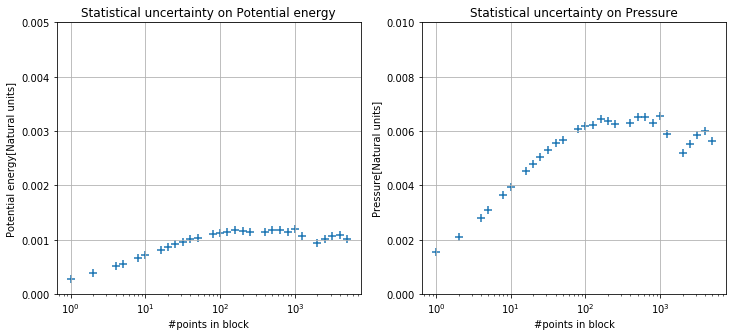

In [31]:
f = plt.figure(figsize = (12, 5))   
text = ['Potential energy', 'Pressure']
for i in range(2):
    f.add_subplot(1, 2, 1+i)          
    plt.scatter((dim_blk), err[i], s = 50, marker = '+')
    plt.xscale('log')
    plt.ylim(0, 0.005*(i+1))
    plt.xlabel('#points in block')
    plt.ylabel(text[i]+'[Natural units]')
    plt.title('Statistical uncertainty on ' + text[i])
    plt.grid()


Si osserva chiaramente una crescita dell'incertezza statistica per i primi 100 passi, e una successiva stabilizzazione intorno a un valore costante. Ancora una volta quindi torna questo intervallo temporale di circa 100 step MC,che già era apparso come tempo tipico in cui le correlazioni vanno a 0. I due metodi danno quindi risultati compatibili: la dimensione minima di un blocco per evitare di sottostimare gli errori è quella per cui lecorerlazioni sono andate a 0.

Il valore della dimensione di un blocco che abbiamo scelto per procedere alla fase successiva è quindi $\alpha = 200$.

In [4]:
d = 200
num = 10**5//d

###  Argon e Krypton in fase solida

In quest'ultima parte completiamo la simulazione dell'ensemble canonico calcolando valori medi ed errori con il metodo del blocking e la dimensione del blocco ottimale scelta. Riportiamo i risultati sia in unità naturali che in unità del Sistema Internazionale, ma i grafici li lascimamo in unità naturali.

Ancora una volta usiamo i $10^5$ dati caricati da file senza dover far girare nuovamente il programma.

In [39]:
amu = 1.6605 * 10**(-27)   #kilograms
k_B = 1.38065 * 10**(-23)  #Joules/Kelvin

sigma_Ar = 0.34*10**(-9)      #meters
epsilon_Ar = 120 * k_B        #Joules
m_Ar = 39.948 * amu           #kilograms

sigma_Kr = 0.364*10**(-9)      #meters
epsilon_Kr = 164 * k_B        #Joules
m_Kr = 83.798 * amu            #kilograms

In [37]:
ave_blk = [0, 0]
accum = [0,0]
accum2 = [0,0]

ave = [np.zeros(num), np.zeros(num)]
ave2 = [np.zeros(num), np.zeros(num)]
devstd = [np.zeros(num), np.zeros(num)]

t = np.arange(num)

for i in range(num):
    ave_blk = [0, 0]
    for k in range(i*d, (i+1)*d):    
        ave_blk[0] += obs[0][k]/d          #calcolo il valor medio     
        ave_blk[1] += obs[1][k]/d         # all'interno di un blocco
    accum[0] += ave_blk[0]
    accum[1] += ave_blk[1]
    accum2[0] += ave_blk[0]**2
    accum2[1] += ave_blk[1]**2
    ave[0][i] = accum[0]/(i+1)               # dei blocchi
    ave[1][i] = accum[1]/(i+1)
    devstd[0][i] = np.sqrt((accum2[0]/(i+1) - (accum[0]/(i+1))**2)/(i+1))  #aggiorno il valore 
    devstd[1][i] = np.sqrt((accum2[1]/(i+1) - (accum[1]/(i+1))**2)/(i+1))  #aggiorno il valore 


(U)Natural units: -7.546632851855996 +/- 0.001159927871406876
(P)Natural units: 7.593301801734996 +/- 0.006368906209213909


ARGON: ρ =  4.3234400000000034e-29 m^(-3),   T =  96.0 K
(U) SI units: -1.2503110376297975e-20 +/- 1.9217452987894837e-24 J
(P) SI units: 320080158.73902136 +/- 268468.2584292034 Pa


KRYPTON: ρ =  5.305139840000001e-29 m^(-3),   T =  131.20000000000002 K
(U) SI units: -1.7087584180940568e-20 +/- 2.626385241678961e-24 J
(P) SI units: 356495420.99813926 +/- 299011.67629509885 Pa


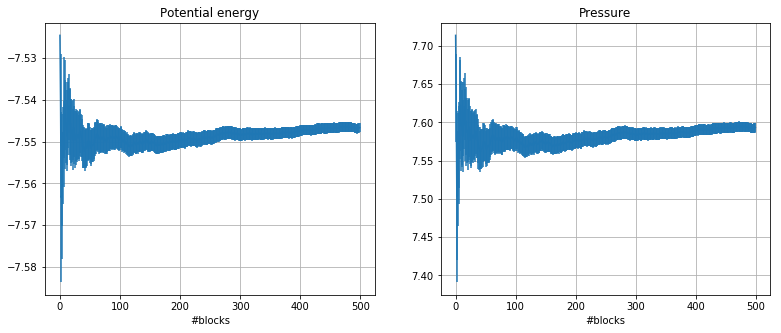

In [60]:
f = plt.figure(figsize = (13, 5))   
text = ['Potential energy', 'Pressure']
for i in range(2):
    f.add_subplot(1, 2, 1+i)          
    plt.errorbar(t, ave[i], devstd[i])
    plt.xlabel('#blocks')
    plt.title(text[i])
    plt.grid()


print("(U)Natural units:", ave[0][num-1], "+/-", devstd[0][num-1])
print("(P)Natural units:", ave[1][num-1], "+/-", devstd[1][num-1])

print("\n")
print ("ARGON: \u03C1 = ", 1.1/sigma_Ar**(-3),"m^(-3), ",    
      " T = " , 0.8*epsilon_Ar/k_B, "K")
print("(U) SI units:", ave[0][num-1] * epsilon_Ar, "+/-" ,
      devstd[0][num-1] * epsilon_Ar, "J")
print("(P) SI units:", ave[1][num-1] * epsilon_Ar/sigma_Ar**3, "+/-" ,
      devstd[1][num-1] * epsilon_Ar/sigma_Ar**3, "Pa")

print("\n")
print ("KRYPTON: \u03C1 = ", 1.1/sigma_Kr**(-3),"m^(-3), ",    
      " T = " , 0.8*epsilon_Kr/k_B, "K")
print("(U) SI units:", ave[0][num-1] * epsilon_Kr, "+/-" ,
      devstd[0][num-1] * epsilon_Kr, "J")
print("(P) SI units:", ave[1][num-1] * epsilon_Kr/sigma_Kr**3, "+/-" ,
      devstd[1][num-1]* epsilon_Kr/sigma_Kr**3, "Pa")


### Funzione di distribuzione radiale

Come abbiamo già visto, la funzione di distribuzione radiale (o RDF) $g(r)$ da informazioni sulle proprietà spaziali (o configurazionali) di un sistema. 

Abbiamo eseguito, per ognuna delle tre fasi, una simulazione di $N = 4000$ passi totali, divisa in 20 blocchi da 200 passi ciascuno. Abbiamo diviso la distanza massima tra due particelle (pari a metà del lato del box della simulazione) in 100 bin, e riempito ad ogni istante un istogramma delle distanze fra le particelle. Mediando infine gli istogrammi all'internodi ogni blocco, abbiamo ottenuto i grafici sottostanti.

Text(0.5, 1.0, 'Radial distribution function')

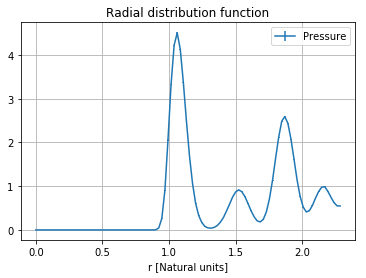

In [11]:
r, gdr, err_gdr = np.loadtxt("RadFunc/Solid/output.gave.0", usecols = (0, 1, 2), unpack = 'true')
plt.errorbar(r, gdr, err_gdr, label = text[i])
plt.xlabel('r [Natural units]')
plt.legend()
plt.grid()
    
plt.title('Radial distribution function')